# Rate Prediction by Collaborative Filtering

In [3]:
# import packages
import numpy as np
import pandas as pd
import altair as alt

In [4]:
# run this if you use Colab
# from google.colab import drive
# drive.mount('/content/drive')
# import io
# from google.colab import files as colab_files
# uploaded = colab_files.upload()

## Data Cleaning

In [5]:
# run this if you use connection to your google drive
# order_reviews = pd.read_csv('drive/Shared drives/671 final project/datasets/olist_order_reviews_dataset.csv')
# orders_dataset = pd.read_csv('drive/Shared drives/671 final project/datasets/olist_orders_dataset.csv')
# order_items_dataset = pd.read_csv('drive/Shared drives/671 final project/datasets/olist_order_items_dataset.csv')
# customers_dataset = pd.read_csv('drive/Shared drives/671 final project/datasets/olist_customers_dataset.csv')

In [6]:
# run this if you use uploading files directly 
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders_dataset = pd.read_csv('olist_orders_dataset.csv')
order_items_dataset = pd.read_csv('olist_order_items_dataset.csv')
customers_dataset = pd.read_csv('olist_customers_dataset.csv')

In [7]:
# merge these four tables: order_reviews, orders_dataset, order_items_dataset, customers_dataset
df_all_orig = order_reviews.merge(orders_dataset,on='order_id').merge(customers_dataset,on='customer_id').merge(order_items_dataset,on='order_id')

In [8]:
# in order to use collaborative filtering, we mainly focus on customer_unique_id, product_id, and review_score. Because review_score is based on order, so 'order_id' is also included, which will be dropped later.
df_customer_product_review = df_all_orig[['customer_unique_id','order_id','product_id','review_score']]

In [9]:
# some orders contain duplicate products, I remove the duplicates as below.
temp = df_customer_product_review[['product_id','order_id']].drop_duplicates()
# we decide to only focus on the orders containing only one product
# the order_id containing only one product
temp2 = temp.groupby('order_id').count()
orderid_1_product = list(temp2[temp2.product_id==1].index)
temp3 = df_customer_product_review[df_customer_product_review.order_id.isin(orderid_1_product)][['customer_unique_id','product_id','review_score']].drop_duplicates()

In [10]:
# To make the review_scores unique, we decide to take the average review_score as the product's review_score
uniq_customer_product_review = temp3.groupby(['customer_unique_id','product_id']).mean().reset_index()
# uniq_customer_product_review dataset can be used for collaberative filtering

In [11]:
uniq_customer_product_review.head()

,customer_unique_id,product_id,review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,372645c7439f9661fbbacfd129aa92ec,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,5099f7000472b634fea8304448d20825,4.0
2,0000f46a3911fa3c0805444483337064,64b488de448a5324c4134ea39c28a34b,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,2345a354a6f2033609bbf62bf5be9ef6,4.0
4,0004aac84e0df4da2b147fca70cf8255,c72e18b3fe2739b8d24ebf3102450f37,5.0


## Data Visulization

In [12]:
################################################################################
# select 1000 of sample from our dataframe "uniq_customer_product_review"      #
# to produce visualization of review_socre and number of customers             #
# REASONS:                                                                     #
# - altair can only take maximun of 5000 rows;                                 #
# - saving overall runtime (if use barplot from seaborn liabrary, although it  #
#   can take all rows in the dataset, it takes too much time to run the code   #
#   so that keyboard interruption has to be involved)                          #
################################################################################

n_list = list(range(0,100,25))
vis_lists = []

for n in n_list:
    sample = uniq_customer_product_review.sample(1000, random_state=n)

    bar = alt.Chart(sample).mark_bar().encode(
        x=alt.X('review_score:Q', bin=alt.Bin(maxbins=5)),
        y=alt.Y('count(customer_unique_id):Q',title="Number of Customers"),
        color = alt.Color('count(product_id):Q',title="Number of Products")
    ).properties(width=150,height=150)

    text = alt.Chart(sample).mark_text(dy=-5).encode(
        x=alt.X('review_score:Q', bin=alt.Bin(maxbins=5)),
        y=alt.Y('count(customer_unique_id):Q',title="Number of Customers"),
        text=alt.Text('count(product_id):Q')
    ).properties(width=150,height=150)

    myvis = bar + text
    
    vis_lists.append(myvis)
    
(vis_lists[0] | vis_lists[1]) & (vis_lists[2] | vis_lists[3])

alt.VConcatChart(...)

In our preprocessed dataset, around 80% of customers having review score over 4, based on the output data visualizations of four sample sets selected from the dataset.

## Model Buiilding

Because we preprocessed the data in terms of its redundency(only focus on the orders containing only one product;use average review_score for each customer) and missingness(no missing value), we can use it directly for our model-building.

In [13]:
# load functions from suprise library and matplotlib
from surprise import SVD,SVDpp, KNNBasic,NMF,CoClustering,BaselineOnly
from surprise import Dataset, Reader, accuracy,NormalPredictor
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold,GridSearchCV
import matplotlib.pyplot as plt

In [14]:
# create reader for review_score
# specify the rating scale to be 1-5 
reader = Reader(rating_scale=(1, 5))
# load dataset
data = Dataset.load_from_df(uniq_customer_product_review, reader)

We constructed two functions for model evaluation:

evaluate_split : split the training data into training and validation, evaluate the RMSE and MAE results for the validation dataset once. This function will be used to tune the parameters.
evaluate_cross : Use 3-folds cross validation to give the final evaluation of the model. This function will be used to compare the performance between different models.

In [18]:
# evaluate the model with splitted dataset
def evaluate_split(model):
    train_data, test_data = train_test_split(data, test_size=.2, random_state=0) 
    model.fit(train_data)
    predictions = model.test(test_data)
    mae = accuracy.mae(predictions)
    rmse = accuracy.rmse(predictions)
    return mae, rmse
# evaluate the model with cross validation 
def evaluate_cross(model):
    return cross_validate(model, data, measures=['MAE','RMSE'], cv=3, verbose=True)

In [14]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), NMF(), KNNBasic(), CoClustering(),BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['mae','rmse'], cv=3, verbose=False)
    print(results)
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_mae')

{'test_mae': array([1.023751  , 1.02705569, 1.02022092]), 'test_rmse': array([1.30946082, 1.31264957, 1.30593318]), 'fit_time': (3.365604877471924, 3.575092315673828, 3.4263670444488525), 'test_time': (0.249222993850708, 0.23592400550842285, 0.15351128578186035)}
{'test_mae': array([1.02198063, 1.03327224, 1.0150777 ]), 'test_rmse': array([1.30865771, 1.32338785, 1.29578214]), 'fit_time': (5.891664981842041, 5.812839031219482, 6.0315163135528564), 'test_time': (0.15291714668273926, 0.16478419303894043, 0.3002660274505615)}
{'test_mae': array([1.0389589 , 1.03988951, 1.03441572]), 'test_rmse': array([1.33212552, 1.33039336, 1.32298715]), 'fit_time': (9.47478199005127, 9.105764150619507, 8.994089365005493), 'test_time': (0.21112704277038574, 0.15172815322875977, 0.2096729278564453)}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similari

,test_mae,test_rmse,fit_time,test_time
Algorithm,,,,
SVDpp,1.023444,1.309276,5.912007,0.205989
BaselineOnly,1.023556,1.307967,0.418906,0.182654
SVD,1.023676,1.309348,3.455688,0.212886
CoClustering,1.027539,1.324720,7.373174,0.150986
KNNBasic,1.031234,1.321180,139.583672,0.555609
NMF,1.037755,1.328502,9.191545,0.190843


Based on the result, we can see that SVD ++ has the best performance without parameter tuning. Next, we'll try to tune hyperparameters to reduce the MAE and RMSE score.

## Tune Hyperparameters of SVD++

The SVD++ is an extension of SVD taking into account implicit ratings(i.e.modeling a user rated an item regardless of the rating value). Since this algorithm has more variables to estimate. It has much longer fitting time than SVD.

I tuned the the following parameters for SVD++:

- lr_all: This parameter controls the learning rate (i.e. the step for updating) of all parameters. The default learning rate is 0.007, which is fairly small and resulting in an extremely slow convergence. Thus I will tune the learning rate as the first step.
- n_epochs: This parameter is tuned in order to make sure the model is converged (i.e. the model is fully trained).
- n_factors: This parameter controls the number of factors. Since SVD is a factorization-based algorithm, this parameter is important to be tuned.
- reg_all: This parameter controls the model generaliation and prevent it to be overfitted. This parameter controls regularization term for all parameters. I will apply the same regularization term for all parameters in this model, thus won't tune other specific regularization term (e.g. reg_bu,reg_qi,etc.).

In [20]:
# define a SVD++ model and get initial mae score
algo = SVDpp()
evaluate_split(algo)

MAE:  1.0175
RMSE: 1.3013


(1.0174921123244371, 1.301290440654185)

In [23]:
def show_result(params,scores):
    return pd.DataFrame(list(zip(params, scores)), 
               columns =['Params', 'Scores'])

MAE:  1.0123
RMSE: 1.3106
MAE:  1.0137
RMSE: 1.3110
MAE:  1.0156
RMSE: 1.3111
MAE:  1.0173
RMSE: 1.3087
MAE:  1.0176
RMSE: 1.3064
MAE:  1.0176
RMSE: 1.3018
   Params                                    Scores
0   0.100      (1.0122791673313, 1.310643244058434)
1   0.050    (1.013732221536518, 1.310965920567966)
2   0.020   (1.015632419666307, 1.3110599688560682)
3   0.010   (1.017286466662846, 1.3086681702341678)
4   0.007  (1.0176456626476222, 1.3063611835100413)
5   0.001   (1.0176243063571513, 1.301836953565734)


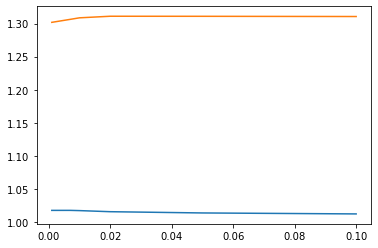

In [25]:
# find the best learning rate for model to converge
lr_list = [0.1,0.05,0.02,0.01,0.007,0.001]
##### please UNCOMMENT the following code to get the score #####
lr_score = []
for l in lr_list:
    svdpp_model = SVDpp(random_state=0,n_factors=10,n_epochs=50,lr_all=l)
    lr_score.append(evaluate_split(svdpp_model))
#################################################################
print(show_result(lr_list,lr_score))

In [27]:
# find number of epochs for model to converge
epoch_list = [1,5,10,20,30,50,100,150,200]
##### please UNCOMMENT the following code to get the score #####
epoch_score = []
for e in epoch_list:
    svdpp_model = SVDpp(random_state=0,n_factors=10,n_epochs=e,lr_all=0.1)
    epoch_score.append(evaluate_split(svdpp_model))
#################################################################
print(show_result(epoch_list,epoch_score))

MAE:  1.0225
RMSE: 1.3062
MAE:  1.0249
RMSE: 1.3115
MAE:  1.0206
RMSE: 1.3126
MAE:  1.0165
RMSE: 1.3119
MAE:  1.0147
RMSE: 1.3114
MAE:  1.0123
RMSE: 1.3106
MAE:  1.0095
RMSE: 1.3094
MAE:  1.0084
RMSE: 1.3088
MAE:  1.0078
RMSE: 1.3084
   Params                                    Scores
0       1   (1.022487721966232, 1.3062051030416615)
1       5   (1.0248952070928765, 1.311504731808819)
2      10  (1.0205794989318193, 1.3126402843096745)
3      20   (1.016508739703818, 1.3118761319346681)
4      30  (1.0146825565654132, 1.3113813503932021)
5      50      (1.0122791673313, 1.310643244058434)
6     100  (1.0094774659234695, 1.3093711718394134)
7     150  (1.0083554233884024, 1.3087797693228564)
8     200  (1.0077735816069493, 1.3084448077860253)


In [28]:
factor_list = [2,5,10,20,30,50,100]
##### please UNCOMMENT the following code to get the score #####
factor_score = []
for f in factor_list:
    svdpp_model = SVDpp(random_state=0,n_factors=f,n_epochs=200,lr_all=0.1)
    factor_score.append(evaluate_split(svdpp_model))
#################################################################
print(show_result(factor_list,factor_score))

MAE:  1.0108
RMSE: 1.3147
MAE:  1.0090
RMSE: 1.3114
MAE:  1.0078
RMSE: 1.3084
MAE:  1.0073
RMSE: 1.3058
MAE:  1.0075
RMSE: 1.3044
MAE:  1.0076
RMSE: 1.3026
MAE:  1.0081
RMSE: 1.3008
   Params                                    Scores
0       2  (1.0108475110561954, 1.3146734933853546)
1       5   (1.0089983082927882, 1.311446783513594)
2      10  (1.0077735816069493, 1.3084448077860253)
3      20  (1.0073041960206501, 1.3058162851569033)
4      30  (1.0075046199894222, 1.3044368397512849)
5      50  (1.0076403076519913, 1.3026076492055212)
6     100   (1.008143821100858, 1.3007970853146573)


In [30]:
reg_list = [0.05,0.02,0.01,0.005,0.001,0]
##### please UNCOMMENT the following code to get the score #####
reg_score = []
for r in reg_list:
    svdpp_model = SVDpp(random_state=0,n_factors=20,n_epochs=200,reg_all=r,lr_all=0.1)
    reg_score.append(evaluate_split(svdpp_model))
#################################################################
print(show_result(reg_list,reg_score))

MAE:  1.0060
RMSE: 1.3059
MAE:  1.0073
RMSE: 1.3058
MAE:  1.0090
RMSE: 1.3059
MAE:  1.0115
RMSE: 1.3062
MAE:  1.0174
RMSE: 1.3069
MAE:  1.0261
RMSE: 1.3084
   Params                                    Scores
0   0.050  (1.0059998888743553, 1.3059133452192737)
1   0.020  (1.0073041960206501, 1.3058162851569033)
2   0.010   (1.0090494892358515, 1.305894637885363)
3   0.005  (1.0115358031935517, 1.3062443920546691)
4   0.001   (1.0174160664008305, 1.306855240290056)
5   0.000     (1.02607896646758, 1.308426954606012)


In [31]:
final_svdpp_model = SVDpp(random_state=0,n_factors=20,n_epochs=200,reg_all=0.05,lr_all=0.1)
evaluate_split(final_svdpp_model)

MAE:  1.0060
RMSE: 1.3059


(1.0059998888743553, 1.3059133452192737)

In [32]:
evaluate_cross(final_svdpp_model)

Evaluating MAE, RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
MAE (testset)     1.0141  1.0182  1.0143  1.0155  0.0019  
RMSE (testset)    1.3189  1.3171  1.3131  1.3164  0.0024  
Fit time          52.56   51.93   51.54   52.01   0.42    
Test time         0.14    0.14    0.31    0.20    0.08    


{'test_mae': array([1.01410433, 1.01821737, 1.01428269]),
 'test_rmse': array([1.31889596, 1.3171385 , 1.313113  ]),
 'fit_time': (52.55998206138611, 51.933927059173584, 51.540509939193726),
 'test_time': (0.13608098030090332, 0.13899993896484375, 0.3140432834625244)}

We could find that the result doesn't have a great improvement by tuning hyperparameters. The reason may be the imbalanced dataset, over 80% of the ratings are over 4. SVD++ has the best performance, which MAE is 1.0060 and RMSE is 1.3059.